In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

import openpyxl

In [2]:
dfFao = pd.read_csv("FAOSTAT.csv")
dfCountries = pd.read_csv("iso-country-codes.csv")
dfConsumption = pd.read_csv("oecd_meat_consumption.csv")

dfFao.head(2)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate


In [3]:
dfCountries.head(2)

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


In [4]:
dfConsumption.head(2)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN


## Pasos para limpiar dfCountries
1. Seleccionar solo aquellas columnas necesarias.
2. Renombrar las columnas al igual que las columnas en los otros dataset para luego hacer los joins.
3. Revisar qué valores de dfCountries no hacen correspondencia con los códigos o nombres usados en los otros datasets.

### Paso 1 y 2

In [5]:
dfCountries = dfCountries[['Alpha-3 code', 'English short name lower case']] \
    .rename(columns={'Alpha-3 code': 'LOCATION', 'English short name lower case':'Area'})
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


### Paso 3: emparejado de valores

In [6]:
def unirDf(df1, df2, columna):
    df1 = df1.merge(df2, on=columna, how='left', indicator=True)
    print('valores que no hacen correspondencia:')
    print(df1[df1['_merge'] != 'both'])
    return df1


dfUnicosEnConsumo = pd.DataFrame(dfConsumption['LOCATION'].unique(), columns = ['LOCATION'])
dfJoinedConsumptionAndCountries = unirDf(dfUnicosEnConsumo, dfCountries, 'LOCATION')

valores que no hacen correspondencia:
   LOCATION Area     _merge
32      WLD  NaN  left_only
33     OECD  NaN  left_only
34    BRICS  NaN  left_only


Esto es esperado, pues el dataset de consumo de OEDC usa esos tres valores para poner valores especiales para su propio análisis.

Ahora, quitamos esos valores y revisamos cuáles valores no están en el dataset de producción de FAO.

In [7]:
dfConsumptionOK = dfJoinedConsumptionAndCountries[dfJoinedConsumptionAndCountries['_merge'] == 'both'][['Area']]

def corroborarValoresEnFAO(df):
    dfUnicosEnFao = pd.DataFrame(dfFao['Area'].unique(), columns = ['Area'])
    _ = unirDf(df, dfUnicosEnFao, 'Area')
    
corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
              Area     _merge
3      South Korea  left_only
6           Turkey  left_only
7    United States  left_only
17            Iran  left_only
26          Russia  left_only
31         Vietnam  left_only
34  United Kingdom  left_only


Vale acotar que **FAO no tiene datos para Turquía**.

Correcciones a valores en dfFao

In [8]:
def corregirValorEnFao(malo, bueno, columma='Area'):
    dfFao.loc[dfFao[columma] == malo, columma] = bueno

corregirValorEnFao('Republic of Korea', 'South Korea')
corregirValorEnFao('United States of America', 'United States')
corregirValorEnFao('Iran (Islamic Republic of)', 'Iran')
corregirValorEnFao('Russian Federation', 'Russia')
corregirValorEnFao('Viet Nam', 'Vietnam')
corregirValorEnFao('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
corregirValorEnFao('Türkiye', 'Turkey')

corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
Empty DataFrame
Columns: [Area, _merge]
Index: []


In [9]:
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


----

## Pasos para limpiar dfConsumption
Pasos:
1. Unir los datos de Consumo con los países.
2. Quitar los códigos de 'Location' propios del análisis de la OECD.
3. Remover entradas para Turquía.
4. Quitar columnas innecesarias.

### 1. Unir datos con dataframe de países

In [10]:
dfConsumption = dfConsumption.merge(dfCountries, on='LOCATION', how='left', indicator=True)
dfConsumption.head(5)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both
3,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1993,26.370,NaN,Australia,both
4,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1994,25.662,NaN,Australia,both


In [11]:
dfConsumption[dfConsumption['_merge'] != 'both']['LOCATION'].unique()

array(['WLD', 'OECD', 'BRICS'], dtype=object)

### 2. Remover Location extras

Remover filas cuando el 'Location' es 'WLD', 'OECD' o 'BRICS'.

Esos son valores totales usados por OECD para comparaciones que no son necesarios para nuestro análisis.

In [12]:
dfConsumption = dfConsumption[dfConsumption['_merge'] == 'both']
dfConsumption.head(3)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both


### 3. Remover Turquía

In [13]:
#dfConsumption = dfConsumption[dfConsumption['Area'] != 'Turkey']

### 4. Columnas innecesarias
Descubriendo cuáles columnas son innecesarias:
- Location (se sustituye por Area).
- Flag Codes que son solo nulos.
- Frecuencia: que siempre es A de Anual.
- Indicador: que siempre es MEATCONSUMP.
- Columnas de códigos redundantes como Year Code, Item Code, Element Code, Area Code

In [14]:
dfConsumption['Flag Codes'].unique()

array([nan])

In [15]:
dfConsumption['FREQUENCY'].unique()

array(['A'], dtype=object)

In [16]:
dfConsumption['INDICATOR'].unique()

array(['MEATCONSUMP'], dtype=object)

In [17]:
dfConsumption = dfConsumption[['Area', 'SUBJECT', 'MEASURE', 'TIME', 'Value']]
dfConsumption.head(3)

,Area,SUBJECT,MEASURE,TIME,Value
0,Australia,BEEF,KG_CAP,1990,0.000
1,Australia,BEEF,KG_CAP,1991,27.942
2,Australia,BEEF,KG_CAP,1992,26.405


----

## Pasos para limpiar dfFao
Este dataset contiene datos de la producción total en toneladas.

Para nuestro análisis solo nos interesa la producción, para poder compararla con el consumo (dfConsumption).

In [18]:
dfFao.head(5)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate
2,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1963,1963,tonnes,47250.0,F,FAO estimate
3,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1964,1964,tonnes,48000.0,F,FAO estimate
4,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1965,1965,tonnes,48700.0,F,FAO estimate


In [19]:
dfFao = dfFao[['Area', 'Item', 'Year', 'Value']]
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,"Meat, cattle",1961,43000.0
1,Afghanistan,"Meat, cattle",1962,45800.0
2,Afghanistan,"Meat, cattle",1963,47250.0


In [20]:
dfFao = dfFao[dfFao['Value'] != None]

---
---

# Primeros Gráficos

In [21]:
corregirValorEnFao('Meat, cattle', 'BEEF', 'Item')
corregirValorEnFao('Meat, chicken', 'POULTRY', 'Item')
corregirValorEnFao('Meat, sheep', 'SHEEP', 'Item')
corregirValorEnFao('Meat, pig', 'PIG', 'Item')


In [22]:
dfFao['Item'].unique()

array(['BEEF', 'POULTRY', 'SHEEP', 'PIG'], dtype=object)

In [23]:
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,BEEF,1961,43000.0
1,Afghanistan,BEEF,1962,45800.0
2,Afghanistan,BEEF,1963,47250.0


In [24]:
dfConsumption2 = dfConsumption[dfConsumption['MEASURE']=='THND_TONNE']
dfConsumption2.head(3)

,Area,SUBJECT,MEASURE,TIME,Value
5600,South Korea,SHEEP,THND_TONNE,1990,9.563
5601,South Korea,SHEEP,THND_TONNE,1991,7.896
5602,South Korea,SHEEP,THND_TONNE,1992,15.467


In [25]:
new_df = pd.merge(dfConsumption2.rename(columns={'Value': 'Consumption'}), 
                  dfFao.rename(columns={'Value': 'Production'}),
                  how='left',
                  left_on=['Area','SUBJECT', 'TIME'], right_on = ['Area','Item', 'Year'])
new_df = new_df[['Area', 'Item', 'TIME', 'Consumption', 'Production']]

#cambiar escala de consumo pues está en miles de toneladas
new_df['Consumption'] = new_df['Consumption'] * 1000

new_df.head(10)

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9563.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0
2,South Korea,SHEEP,1992,15467.0,29.0
3,South Korea,SHEEP,1993,11516.0,8.0
4,South Korea,SHEEP,1994,14189.0,7.0
5,South Korea,SHEEP,1995,12722.0,7.0
6,South Korea,SHEEP,1996,10887.0,7.0
7,South Korea,SHEEP,1997,9606.0,6.0
8,South Korea,SHEEP,1998,8067.0,5.0
9,South Korea,SHEEP,1999,6814.0,5.0


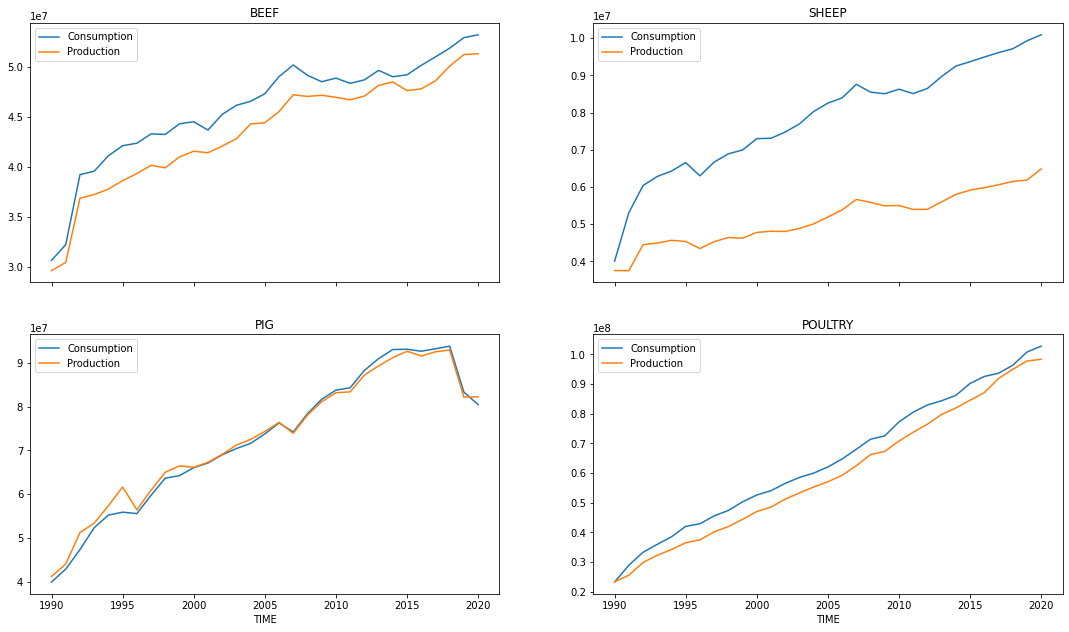

In [26]:
fig, ax = plt.subplots(2, 2, sharex='col')
ejes = ax.flatten()
tipos = ['BEEF', 'SHEEP', 'PIG', 'POULTRY']

fig.set_size_inches(18.5, 10.5)

for i in range(4):
    new_df.where(new_df['Item']==tipos[i]) \
        .groupby('TIME') \
        .sum() \
        .plot(title=tipos[i], ax=ejes[i])
fig.savefig('porTipo.png', dpi=100)

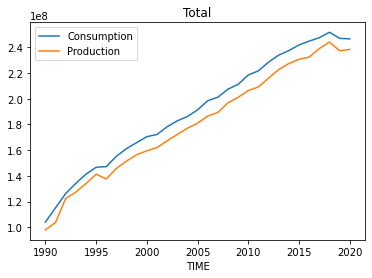

In [27]:
axe = new_df.where(new_df['TIME']<2021).groupby('TIME').sum().plot(title='Total')
axe.get_figure().savefig('total.png', dpi=100)

In [28]:
paises = new_df['Area'].unique()
print(len(paises))
paises

35


array(['South Korea', 'South Africa', 'India', 'Norway', 'Ethiopia',
       'Ukraine', 'Saudi Arabia', 'Russia', 'Thailand', 'Kazakhstan',
       'Israel', 'Egypt', 'United States', 'Nigeria', 'Vietnam',
       'New Zealand', 'Peru', 'Turkey', 'Japan', 'Brazil', 'Indonesia',
       'Argentina', 'Colombia', 'Malaysia', 'Iran', 'Switzerland',
       'Pakistan', 'Canada', 'Chile', 'Philippines', 'Australia', 'China',
       'Mexico', 'Paraguay', 'United Kingdom'], dtype=object)

In [29]:
len(dfFao['Area'].unique())

209

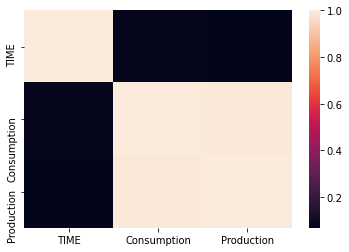

In [30]:
axe = sns.heatmap(new_df.corr())
axe.get_figure().savefig('correlation.png', dpi=100)

In [31]:
new_df.corr()

,TIME,Consumption,Production
TIME,1.000000,0.077064,0.068393
Consumption,0.077064,1.000000,0.991085
Production,0.068393,0.991085,1.000000


In [32]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import category_encoders as ce


In [33]:
new_df.head(150)

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9563.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0
2,South Korea,SHEEP,1992,15467.0,29.0
3,South Korea,SHEEP,1993,11516.0,8.0
4,South Korea,SHEEP,1994,14189.0,7.0
...,...,...,...,...,...
145,India,SHEEP,2015,708951.0,248467.0
146,India,SHEEP,2016,722370.0,258335.0
147,India,SHEEP,2017,711407.0,261211.0
148,India,SHEEP,2018,713248.0,268191.0


In [34]:
encoder = ce.OneHotEncoder()
new_df_enc = encoder.fit_transform(new_df)

In [35]:
new_df_enc.columns

Index(['Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7',
       'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12', 'Area_13',
       'Area_14', 'Area_15', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_25',
       'Area_26', 'Area_27', 'Area_28', 'Area_29', 'Area_30', 'Area_31',
       'Area_32', 'Area_33', 'Area_34', 'Area_35', 'Item_1', 'Item_2',
       'Item_3', 'Item_4', 'Item_5', 'TIME', 'Consumption', 'Production'],
      dtype='object')

In [36]:
#split dataset in features and target variable
feature_cols = ['Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7',
       'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12', 'Area_13',
       'Area_14', 'Area_15', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_25',
       'Area_26', 'Area_27', 'Area_28', 'Area_29', 'Area_30', 'Area_31',
       'Area_32', 'Area_33', 'Area_34', 'Area_35', 'Item_1', 'Item_2',
       'Item_3', 'Item_4', 'Item_5', 'TIME']
X = new_df_enc[feature_cols] # Features
y = new_df_enc.Consumption # Target variable

In [37]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [38]:
# Create Decision Tree classifier object
clf = DecisionTreeRegressor()
# Train Decision Tree Classifier
clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

df_pred_test=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_pred_test

,Actual,Predicted
4704,1590551.0,1649933.0
5570,391864.0,378922.0
250,903782.0,810041.0
1727,4644.0,4650.0
2610,91977.0,66462.0
...,...,...
2139,322077.0,374954.0
5061,114126.0,114445.0
1542,153791.0,149201.0
2991,129568.0,271.0


In [39]:
df3 = pd.DataFrame([(1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2025)], 
                   columns=['Area_1', 'Area_2', 'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7',
       'Area_8', 'Area_9', 'Area_10', 'Area_11', 'Area_12', 'Area_13',
       'Area_14', 'Area_15', 'Area_16', 'Area_17', 'Area_18', 'Area_19',
       'Area_20', 'Area_21', 'Area_22', 'Area_23', 'Area_24', 'Area_25',
       'Area_26', 'Area_27', 'Area_28', 'Area_29', 'Area_30', 'Area_31',
       'Area_32', 'Area_33', 'Area_34', 'Area_35', 'Item_1', 'Item_2',
       'Item_3', 'Item_4', 'Item_5', 'TIME'])

df3


,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6,Area_7,Area_8,Area_9,Area_10,...,Area_32,Area_33,Area_34,Area_35,Item_1,Item_2,Item_3,Item_4,Item_5,TIME
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2025


In [40]:

y_pred = clf.predict(df3)

print(y_pred)

[19317.]


In [41]:
new_df

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9563.0,14.0
1,South Korea,SHEEP,1991,7896.0,14.0
2,South Korea,SHEEP,1992,15467.0,29.0
3,South Korea,SHEEP,1993,11516.0,8.0
4,South Korea,SHEEP,1994,14189.0,7.0
...,...,...,...,...,...
5595,United Kingdom,NaN,2025,303964.0,NaN
5596,United Kingdom,NaN,2026,303925.0,NaN
5597,United Kingdom,NaN,2027,304111.0,NaN
5598,United Kingdom,NaN,2028,304370.0,NaN


In [42]:
new_df.query("Area == 'South Korea' & Item == 'SHEEP' & TIME == 2020")

,Area,Item,TIME,Consumption,Production
30,South Korea,SHEEP,2020,19317.0,4.0


In [43]:
new_df = new_df[new_df["Item"] == 'BEEF'] 
new_df = new_df[new_df["Area"] == 'South Korea'] 
new_df = new_df.drop(columns=["Item", "Area","TIME", "Production"])

new_df.describe()

dataset = new_df.values

In [44]:
def convert2matrix(dataset, look_back=1):
    X, Y =[], []
    for i in range(len(dataset)-look_back):
        d=i+look_back  
        X.append(dataset[i:d,0])
        Y.append(dataset[d,0])
    return np.array(X), np.array(Y)

In [45]:
def neural_model(look_back, trainX, trainY, epochs, batch_size):
    model = Sequential()
    model.add(Dense(32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(testX,testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
    return model, history

In [46]:
def history_model_plot(dataset, look_back, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+look_back:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    print(dataset.shape)
    print(trainPredict.shape)
    print(testPredict.shape)
    plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [47]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [48]:
def prediction_plot(testY, test_predict, l):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:l], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:l], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

In [49]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

model, history = neural_model(trainX.shape[1], trainX, trainY, 300, 20)

In [50]:
trainScore = model.evaluate(trainX,trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1])) 

Train Score: 7708841984.00 MSE (55797.09 MAE)
Test Score: 7708841984.00 MSE (55797.09 MAE)


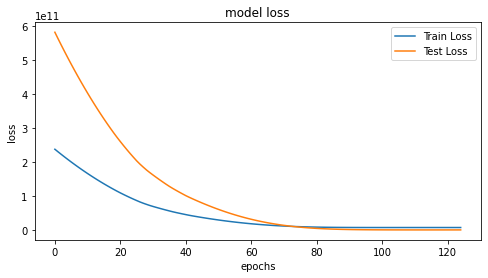

In [51]:
model_loss(history)

In [52]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

(31, 1)
(19, 1)
(10, 1)


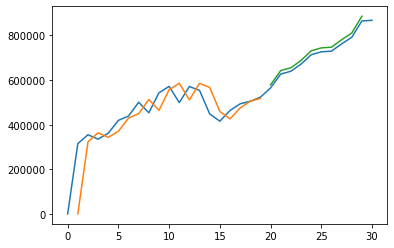

In [53]:
history_model_plot(dataset, look_back, trainPredict, testPredict)

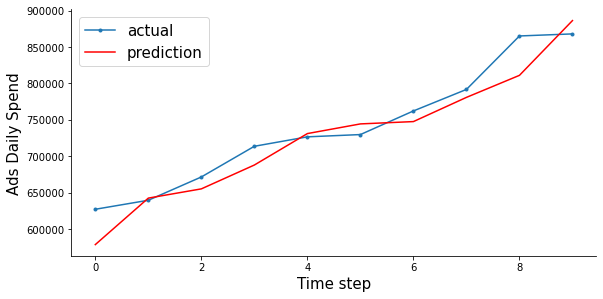

In [54]:
prediction_plot(testY, testPredict, testY.shape[0])

In [55]:
testX

array([[564912.],
       [627210.],
       [639583.],
       [671544.],
       [713675.],
       [726628.],
       [729746.],
       [762168.],
       [791703.],
       [865100.]])

In [56]:
testPredict

array([[578708.56],
       [642528.  ],
       [655203.2 ],
       [687944.7 ],
       [731104.6 ],
       [744374.  ],
       [747568.06],
       [780781.94],
       [811038.2 ],
       [886227.56]], dtype=float32)